In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [58]:
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")["Count"]

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05, method='ywm')
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


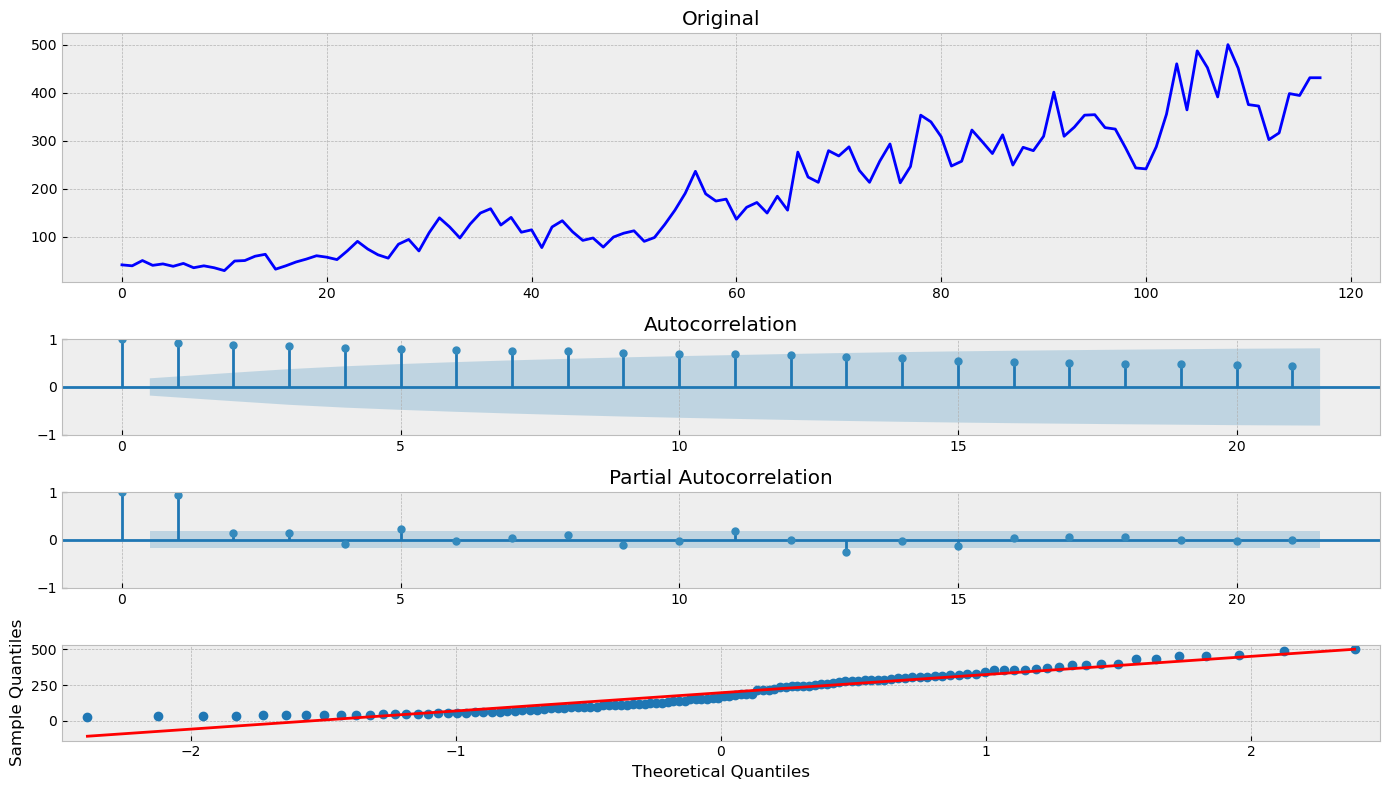

In [59]:
tsplot(robberies_in_boston)

Дифференцируем ряд.

In [72]:
series = np.array(robberies_in_boston[1:]) - np.array(robberies_in_boston[:-1])

Results of Dickey-Fuller Test:
Test Statistic                -7.428564e+00
p-value                        6.450795e-11
#Lags Used                     1.000000e+01
Number of Observations Used    1.060000e+02
Critical Value (1%)           -3.493602e+00
Critical Value (5%)           -2.889217e+00
Critical Value (10%)          -2.581533e+00
dtype: float64


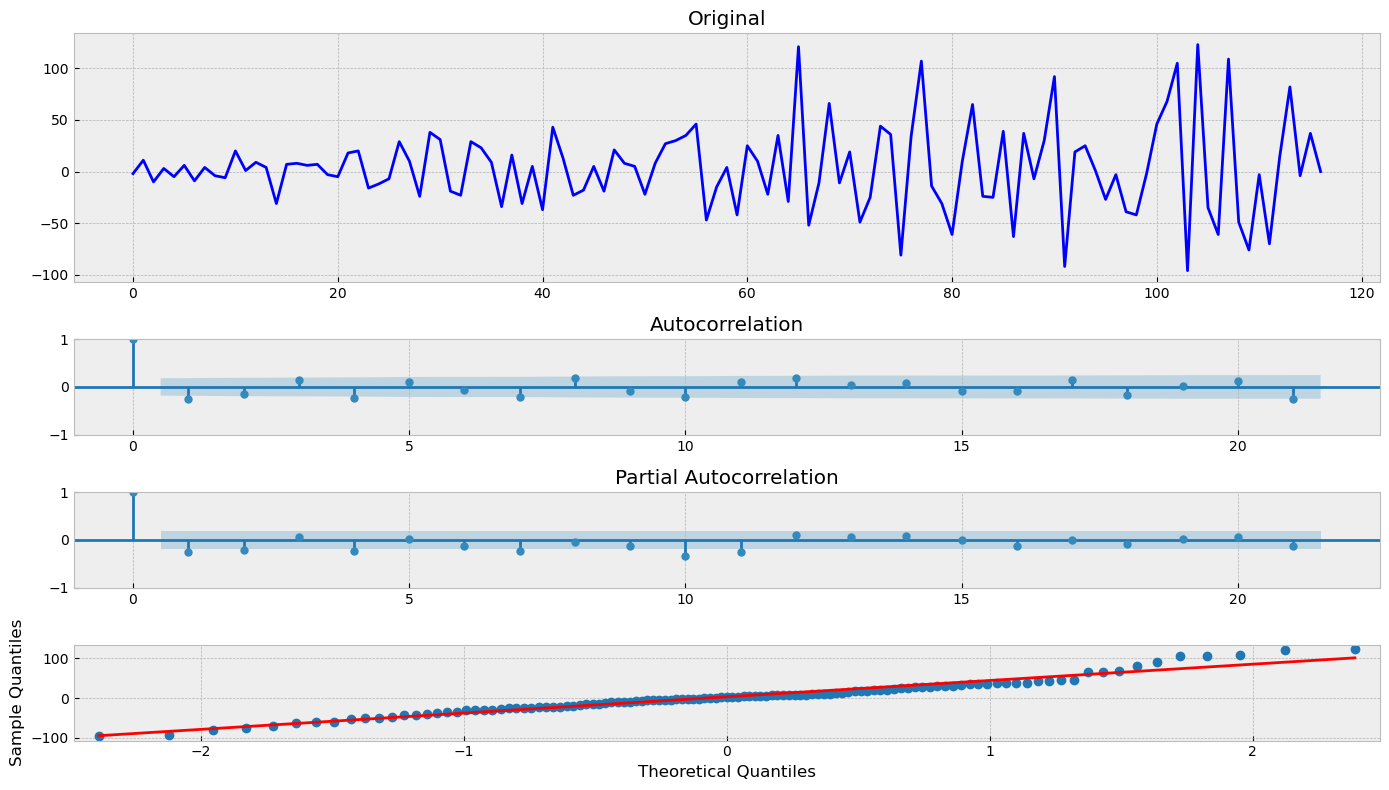

In [74]:
tsplot(series)

In [9]:
from arch import arch_model

Подберем параметры по AIC

In [167]:
import warnings
warnings.filterwarnings("ignore")

In [186]:
best_aic = np.inf 
best_order = None
best_res = None
for i in range(20):
    for d in range(1):
        for j in range(20):
            try:
                tmp_mdl = arch_model(series, vol='GARCH', dist='StudentsT', p=i, o=d, q=j)
                tmp_res = tmp_mdl.fit(update_freq=5, disp="off")
                tmp_aic = tmp_res.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_res = tmp_res
            except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 1160.10915 | order: (1, 0, 1)


In [242]:
am = arch_model(series, vol='GARCH', dist='StudentsT', p=1, o=0, q=1)
res = am.fit(update_freq=5, disp="off")
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -575.055
Distribution:      Standardized Student's t   AIC:                           1160.11
Method:                  Maximum Likelihood   BIC:                           1173.92
                                              No. Observations:                  117
Date:                      Mon, Jun 05 2023   Df Residuals:                      116
Time:                              14:56:46   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1

Results of Dickey-Fuller Test:
Test Statistic                -7.428564e+00
p-value                        6.450795e-11
#Lags Used                     1.000000e+01
Number of Observations Used    1.060000e+02
Critical Value (1%)           -3.493602e+00
Critical Value (5%)           -2.889217e+00
Critical Value (10%)          -2.581533e+00
dtype: float64


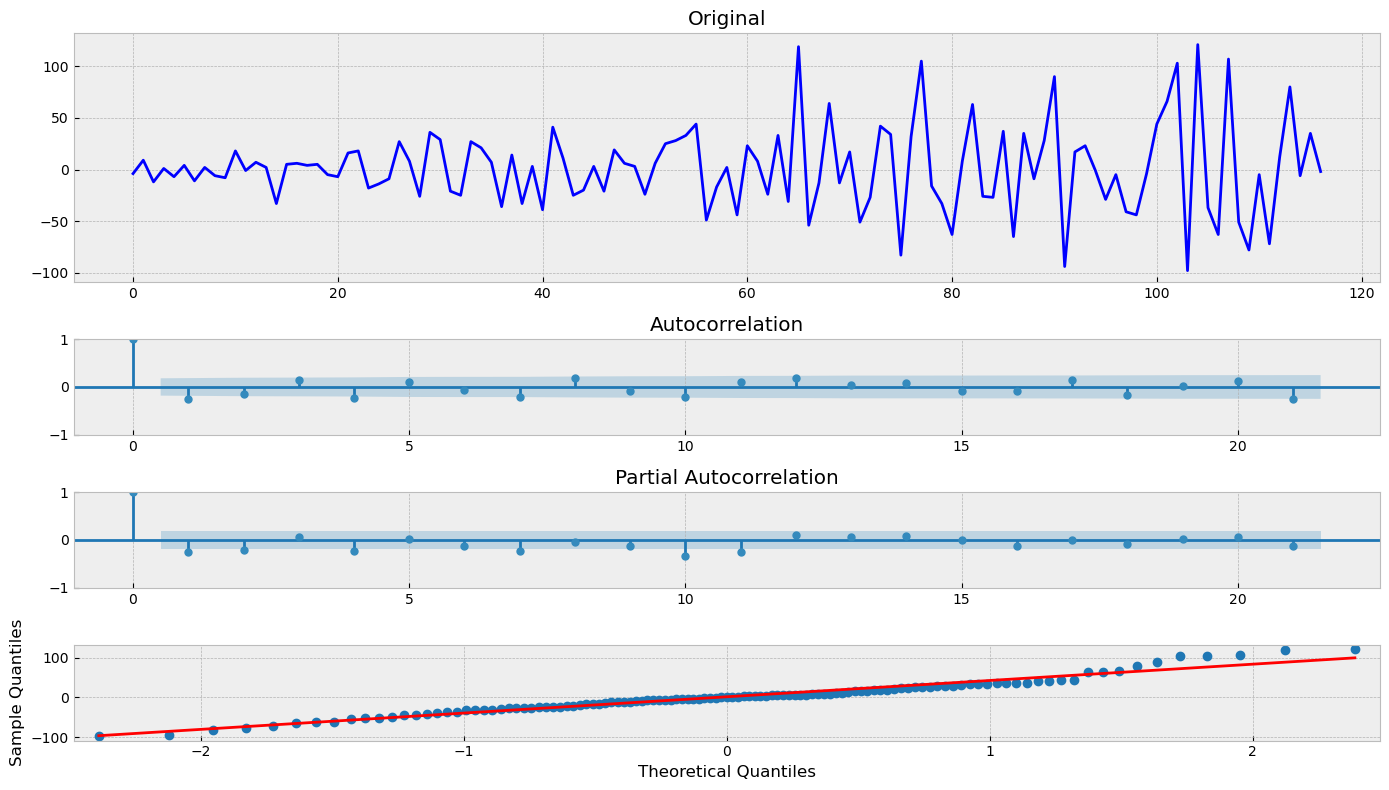

In [245]:
tsplot(res.resid)

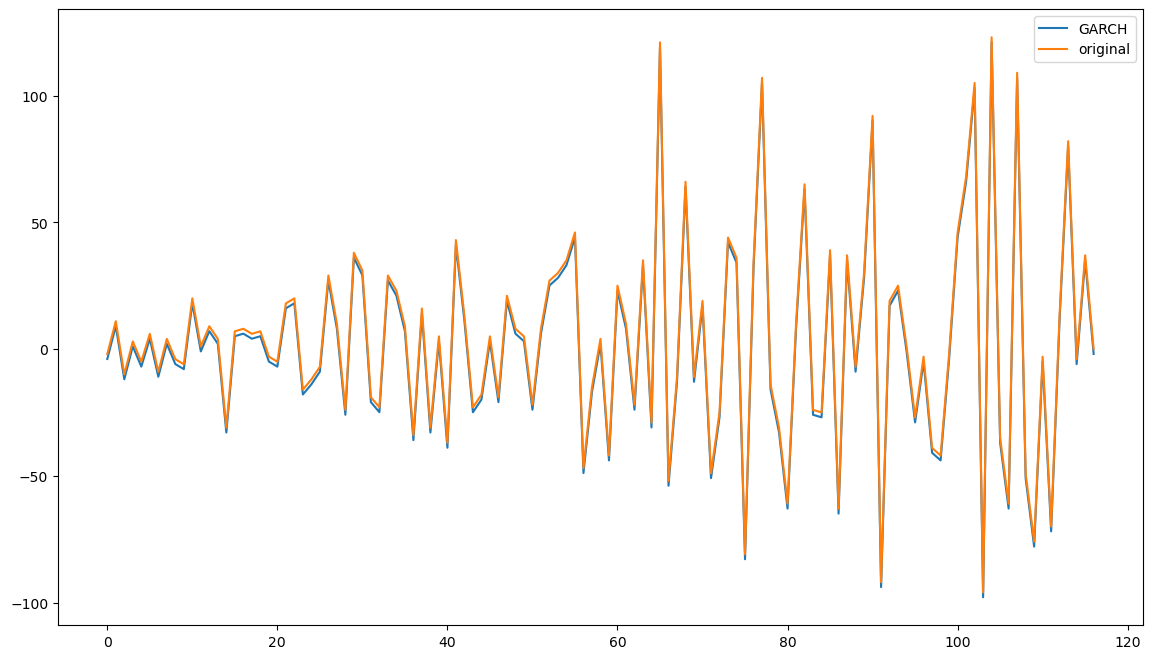

In [246]:
plt.figure(figsize=(14,8))
plt.plot(res.resid, label='GARCH')
plt.plot(series, label='original')
plt.legend(loc="best")
plt.show()

Обратно интергируем ряд

In [247]:
garch_model = np.cumsum(np.concatenate(([robberies_in_boston[0]], res.resid), axis=0))

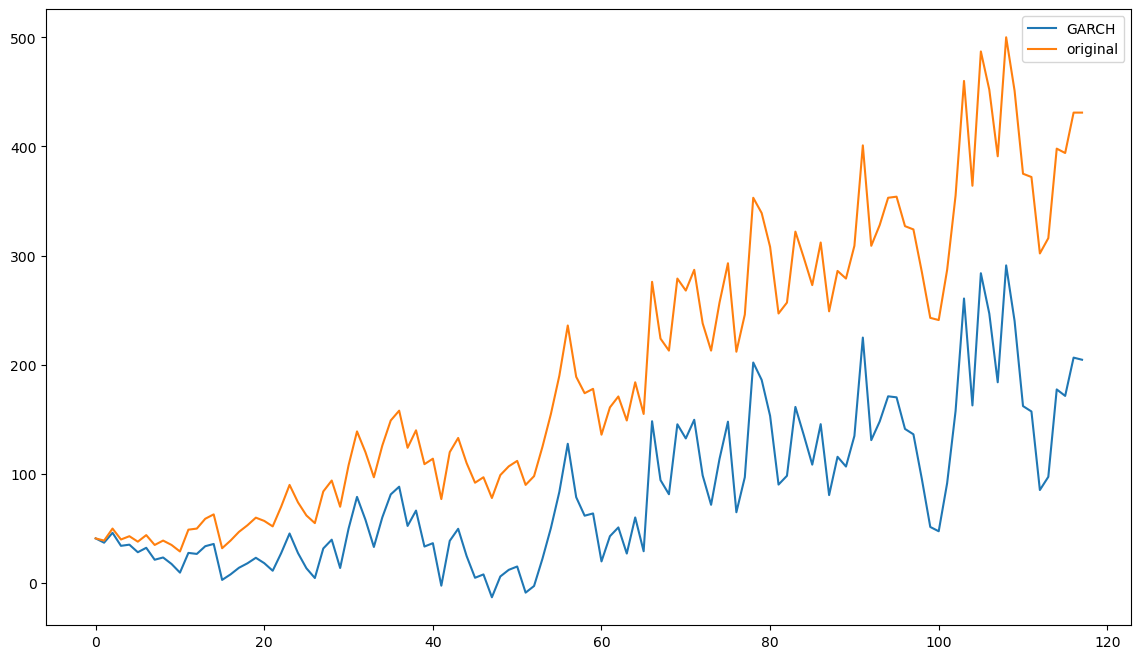

In [248]:
plt.figure(figsize=(14,8))
plt.plot(garch_model, label='GARCH')
plt.plot(robberies_in_boston, label='original')
plt.legend(loc="best")
plt.show()

Накапливается довольно большая ошибка. Попробуем подобрать параметы, чтобы минимизировать росхождение к концу ряда.

In [241]:
best_aic = np.inf 
best_order = None
best_res = [0]
for i in range(10):
    for d in range(2):
        for j in range(10):
            try:
                tmp_mdl = arch_model(series, vol='GARCH', dist='StudentsT', p=i, o=d, q=j)
                tmp_res = tmp_mdl.fit(update_freq=5, disp="off")
                tmp_aic = tmp_res.aic
                if abs(list(robberies_in_boston)[-1] - sum(tmp_res.resid)) < abs(list(robberies_in_boston)[-1] -sum(best_res)):
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_res = tmp_res.resid
                    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
            except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 1200.91038 | order: (0, 1, 0)
aic: 1200.91038 | order: (0, 1, 0)


In [249]:
am = arch_model(series, vol='GARCH', dist='StudentsT', p=0, o=1, q=0)
res = am.fit(update_freq=5, disp="off")
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -596.455
Distribution:      Standardized Student's t   AIC:                           1200.91
Method:                  Maximum Likelihood   BIC:                           1211.96
                                              No. Observations:                  117
Date:                      Mon, Jun 05 2023   Df Residuals:                      116
Time:                              15:00:29   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0

Results of Dickey-Fuller Test:
Test Statistic                -7.428564e+00
p-value                        6.450795e-11
#Lags Used                     1.000000e+01
Number of Observations Used    1.060000e+02
Critical Value (1%)           -3.493602e+00
Critical Value (5%)           -2.889217e+00
Critical Value (10%)          -2.581533e+00
dtype: float64


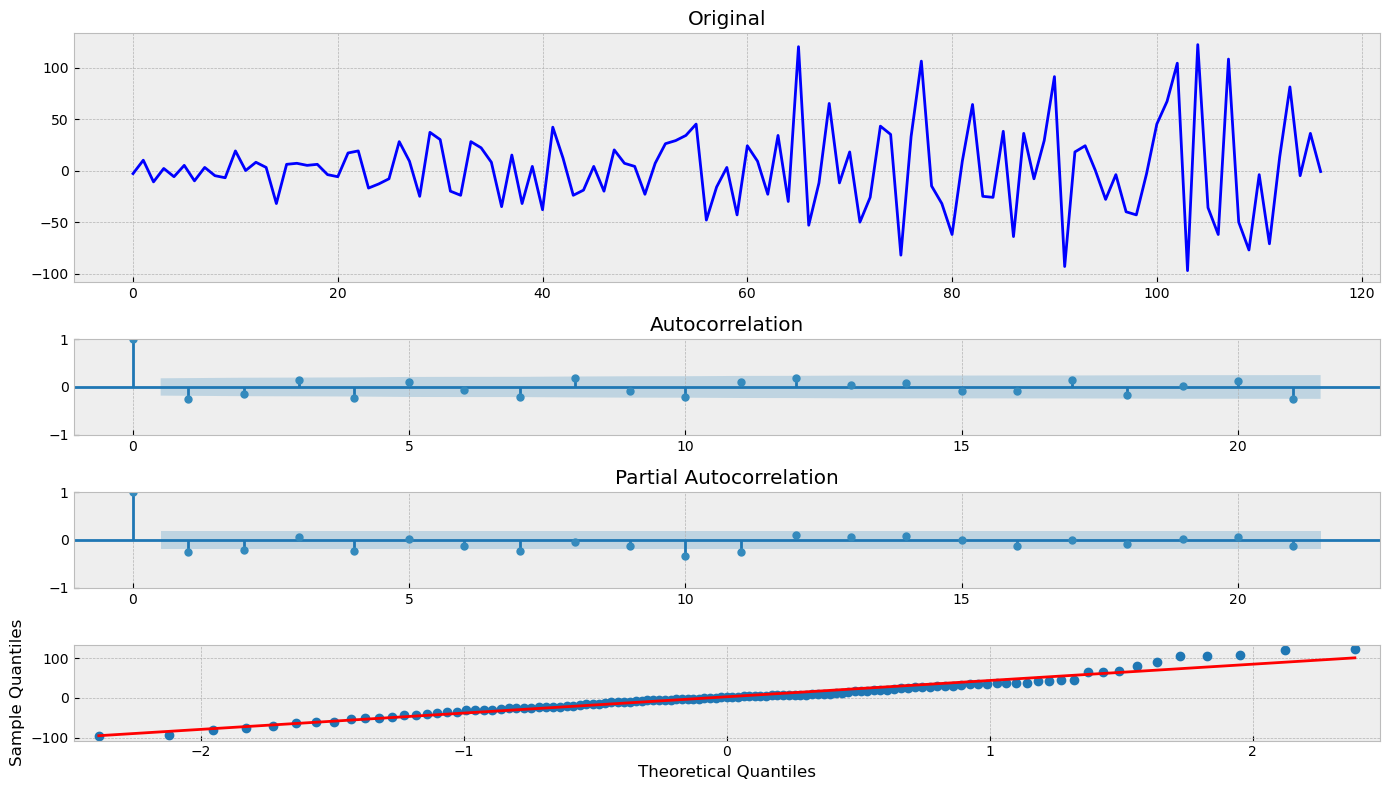

In [250]:
tsplot(res.resid)

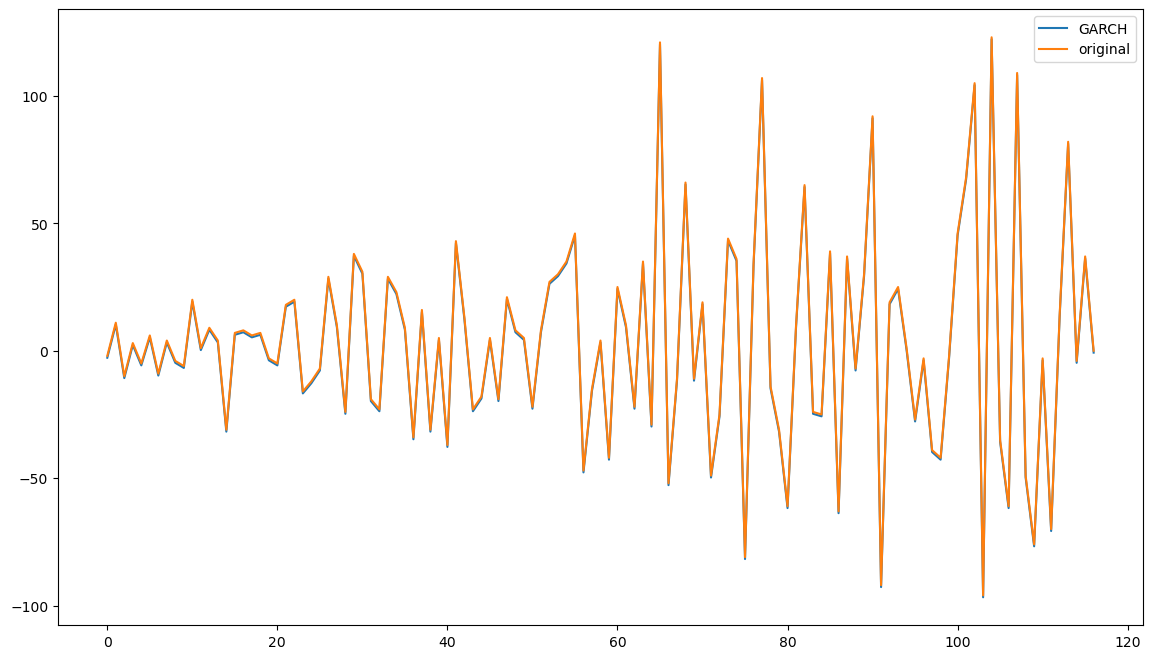

In [251]:
plt.figure(figsize=(14,8))
plt.plot(res.resid, label='GARCH')
plt.plot(series, label='original')
plt.legend(loc="best")
plt.show()

In [252]:
garch_model = np.cumsum(np.concatenate(([robberies_in_boston[0]], res.resid), axis=0))

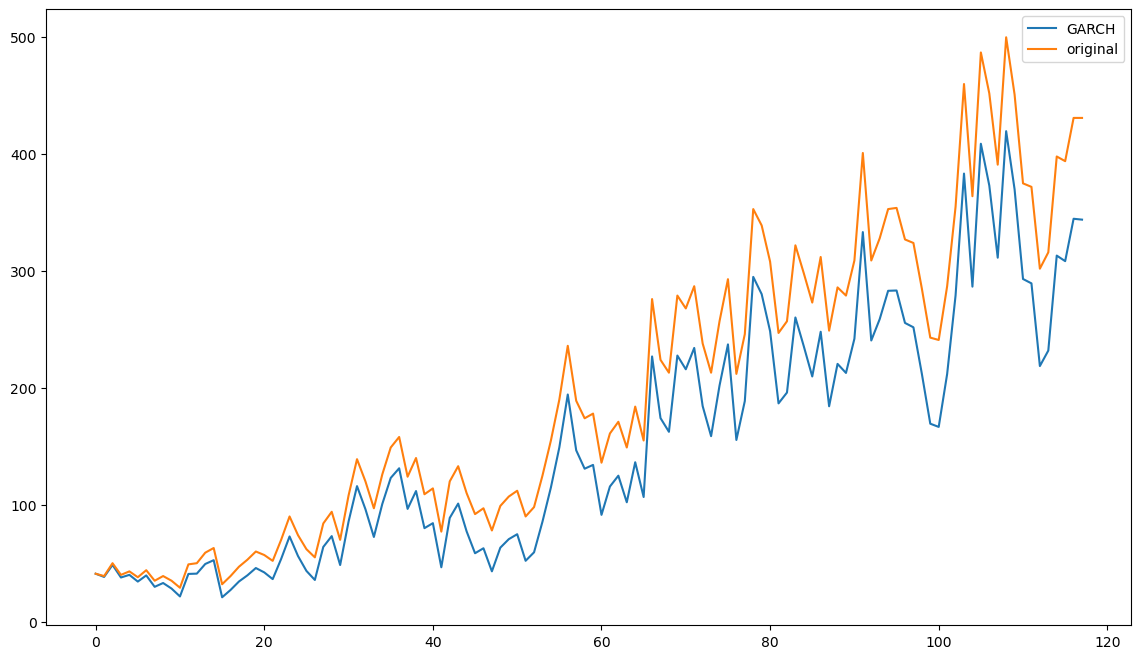

In [253]:
plt.figure(figsize=(14,8))
plt.plot(garch_model, label='GARCH')
plt.plot(robberies_in_boston, label='original')
plt.legend(loc="best")
plt.show()

Расхождение уменьшилось